# Evaluate f1 scores across sequence

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from collections import Counter

import os

c:\Users\Bruger\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
scores = pd.read_csv('../results/distance_table.csv')

## Rank performances  

In [4]:
def rank_distances(input_list: list):
   sorted_list = sorted(input_list, reverse=True)
   rank_dict = {num: rank for rank, num in enumerate(sorted_list, start=1)} 
   return [rank_dict[num] for num in input_list]

def ranked_df(scores: pd.array): 
   """
   Takes the input data frame and returns a new dataframe where each row is ranked with the largest score recieving the lowest rank
   """
   ranked_df = pd.DataFrame(columns=scores.columns)
   
   columns = [name for name in scores.columns if name not in ['length', 'type']]
   distances = scores[columns]

   for idx in range(len(scores)): 
      row_distance =  list(distances.loc[idx])
      ranked_distances =  rank_distances(row_distance)
      new_row = [scores.at[idx, 'length'], scores.at[idx, 'type']] + ranked_distances
      ranked_df.loc[idx] = new_row
   
   return ranked_df


def count_ranks(input_list: list, min_value = 1, max_value = 4): 
    """
    Count how many there are of each rank in input_list and returns a list of the counts ordered from lowest to higest rank

    Args: 
        min_value: Minimum rank (default = 1)
        max_value: Maximum rank(default = 4)

    """
    count_dict = Counter(input_list)
    counts = [count_dict.get(i, 0) for i in range(min_value, max_value+1)]
    return counts

def method_scores(ranked_df, min_rank = 1, max_rank = 4): 
    """
    Takes a data frame with ranks and returns a data fraeme with the counts of each rank for each column in the data frame
    """
    columns = [name for name in ranked_df.columns if name not in ['length', 'type']]
    distances = ranked_df[columns]
    contengiency = pd.DataFrame(columns=columns)

    for column in distances: 
        data = list(distances[column])
        counts = count_ranks(data, min_rank, max_rank)

        contengiency[column] = counts
    
    contengiency.index = [i for i in range(min_rank, max_rank+1)]


    return contengiency   
   

def percent_rank(rank_count_df): 
    df = pd.DataFrame(columns=rank_count_df.columns)

    for column in rank_count_df: 
        column_sum = sum(rank_count_df[column])
        df[column] = round(rank_count_df[column]/column_sum * 100, 2)

    return df


In [60]:
def plot_ranks(rank_count_df: pd.array, percent_df: pd.array, outputfile = None):
    x = np.arange(rank_count_df.shape[1])
    width = 3 / (rank_count_df.shape[1]*rank_count_df.shape[0] + 1) 
    multiplier = 0
     
    fig, ax = plt.subplots(layout = 'constrained', figsize = (9, 10))

    for index, row in rank_count_df.iterrows(): 
        offset = width*multiplier
        rects = ax.bar(x + offset, list(row), width, label = index, zorder = 2, edgecolor = 'black')

        # Adding percentage labels to each bar
        for i, rect in enumerate(rects):
            percent_value = percent_df.iloc[index-1, i]  # Access corresponding cell in percent_df
            ax.annotate(f'{percent_value:.2f}%', 
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(1, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=45,
                        fontsize = 8)
        
        multiplier += 1

    ax.grid(axis = 'y', linestyle = '--')

    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_ylabel('frequency')
    ax.set_xticks(x + width, [name.split('_')[1] for name in rank_count_df.columns])

    plt.legend(title = 'rank', loc='center left', bbox_to_anchor=(1, 0.94))

    if outputfile: 
        plt.savefig(outputfile, bbox_inches = 'tight')
    
    plt.show()

## For comparison between true and predicted structure

,true_OriginalMfold,true_NewestMfold,true_Nussinov,true_MfoldWebversion
1,7,8,2,18
2,18,7,6,4
3,6,15,11,6
4,5,6,17,8


,true_OriginalMfold,true_NewestMfold,true_Nussinov,true_MfoldWebversion
1,19.44,22.22,5.56,50.00
2,50.00,19.44,16.67,11.11
3,16.67,41.67,30.56,16.67
4,13.89,16.67,47.22,22.22


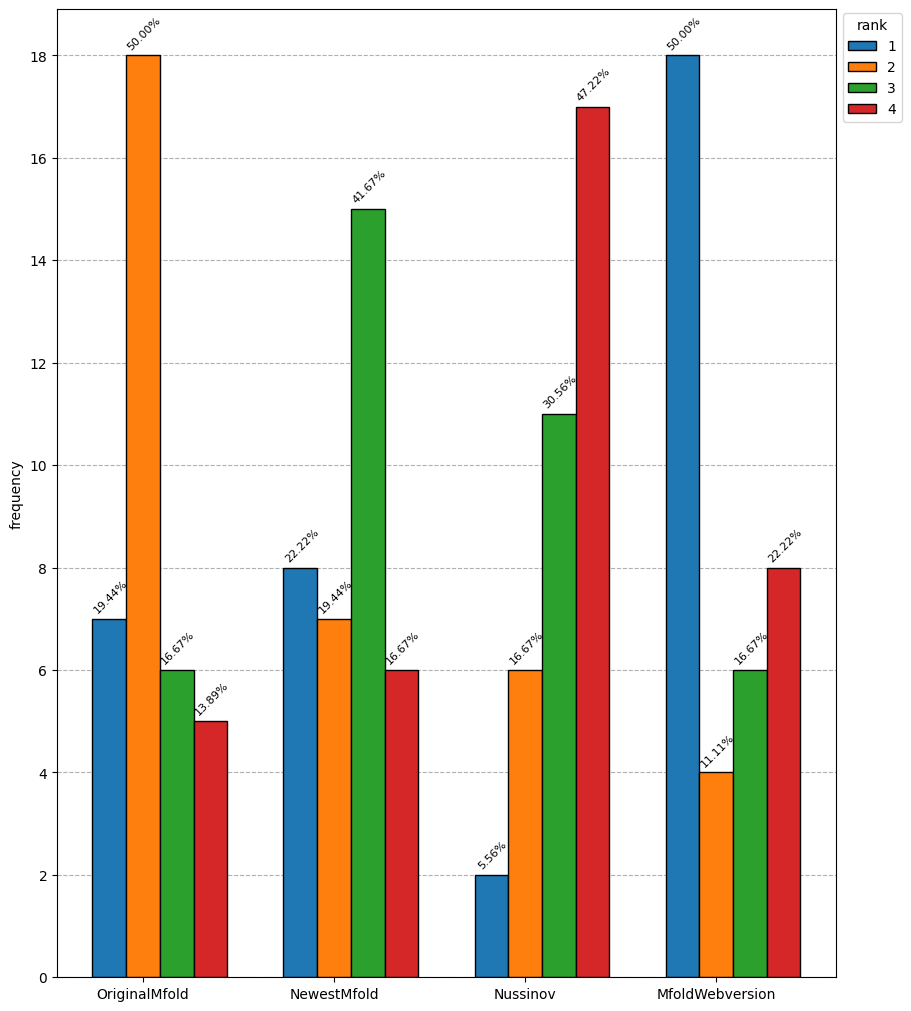

In [63]:
columns = ['length', 'type'] + [name for name in scores.columns if name.startswith('true')]
scores_true = scores[columns]

ranked_true = ranked_df(scores_true)

rank_count_true = method_scores(ranked_true)

percent_true = percent_rank(rank_count_true)

display(rank_count_true)
display(percent_true)

plot_ranks(rank_count_true, percent_true, outputfile = '../figures/ranked_distances_true.jpeg')

## Comparison between structures predited by my Mfold and other algorithms

,NewestMfold_OriginalMfold,NewestMfold_Nussinov,NewestMfold_MfoldWebversion
1,16,6,13
2,13,8,16
3,7,22,7


,NewestMfold_OriginalMfold,NewestMfold_Nussinov,NewestMfold_MfoldWebversion
1,44.44,16.67,36.11
2,36.11,22.22,44.44
3,19.44,61.11,19.44


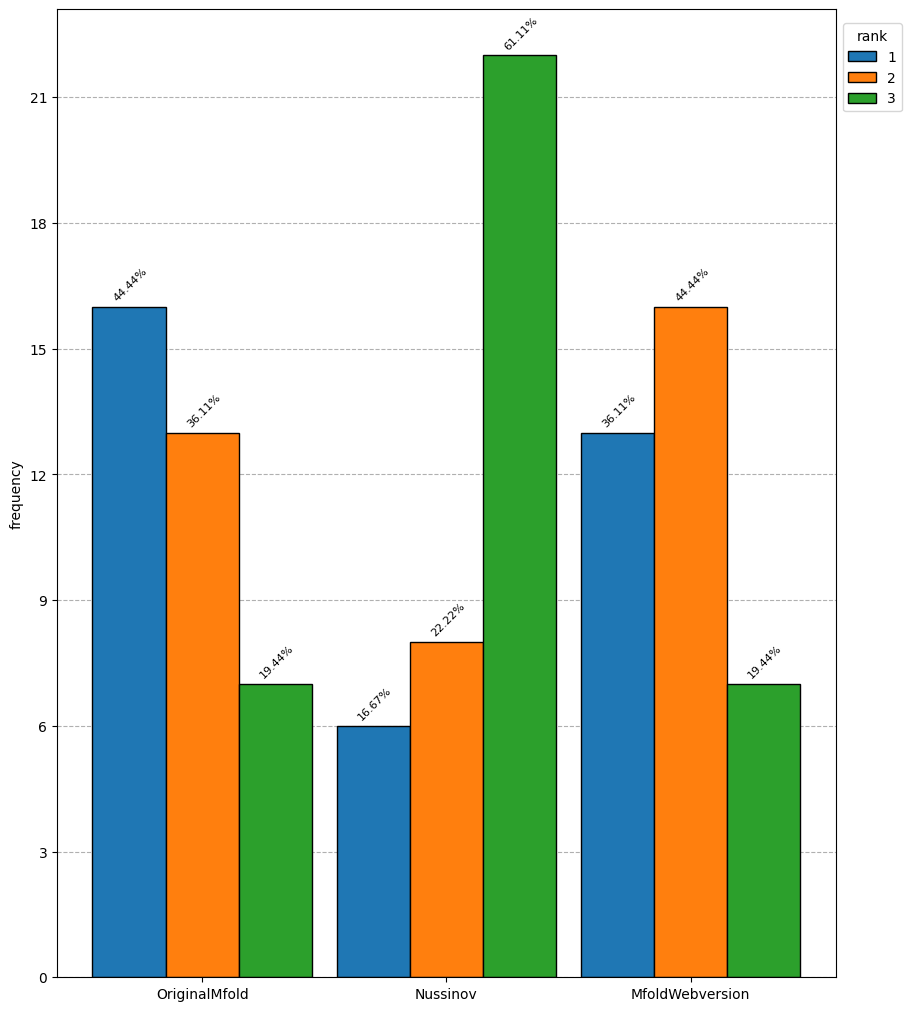

In [65]:
columns = ['length', 'type'] + [name for name in scores.columns if (name.startswith('NewestMfold') and 'true' not in name)]
scores_mfold = scores[columns]

ranked_mfold = ranked_df(scores_mfold)

rank_count_mfold = method_scores(ranked_mfold, max_rank=3)

percent_mfold = percent_rank(rank_count_mfold)

display(rank_count_mfold)
display(percent_mfold)

plot_ranks(rank_count_mfold, percent_mfold, outputfile = '../figures/ranked_distances_NewestMfold.jpeg')
